# Utilities

## Notes

Run with `--NotebookApp.iopub_data_rate_limit=10000000000`

Mettre nombre de pts par game comme target et enlever les instances ou un joueur a joue moins de 40 matchs ou de quoi dans la saison

For player with less than 3 seasons, add mean of average number of points to be able to have 3 seasons studied (add 2 synthetic seasons if one player has 1 season played)

**Fitter une regression lineaire, parce que les gars qui font peu de points sont overshoot, et les gars qui en font beaucoup sont undershoot**

In [1]:
import pandas as pd
import numpy as np
import re
import math
import pickle
import glob
import xgboost
import tsfresh
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from pprint import pprint
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score, log_loss
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_context('notebook')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 100, 'linewidths':0}
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, reset_output
reset_output()
output_notebook()

Loading BokehJS ...

---
# Read datasets

In [3]:
def read_dataset(file_paths_regex):
    data_paths = glob.glob(file_paths_regex)
    data_paths.sort()
    
    data = pd.DataFrame()
    for file_path in data_paths:
        file = pd.read_csv(file_path, sep=',', encoding="utf-8-sig")
        file['Year'] = '20' + file_path.split('-')[2]
        file = file.rename(columns={'Unnamed: 0': 'Index'}).set_index('Index')
        data = pd.concat([data, file], sort=False)
    data['Name'] = data.apply(lambda player: re.sub(r'\W+', '', f'{player["Player"]})').upper(), axis=1)
    data.set_index('Name', inplace=True)
    return data

In [4]:
# # Read the 3 kinds of datasets
# individuals = read_dataset('./nhl-stats_rates/*ind.csv')
# on_ice = read_dataset('./nhl-stats_rates/*ice.csv')
# on_ice.drop(['GP', 'TOI'], axis=1, inplace=True) # Because already in individuals
# biography = read_dataset('./nhl-stats_rates/*bio.csv')

# Read the 3 kinds of datasets
individuals = read_dataset('./nhl-stats_rates/*ind-rates.csv')
on_ice = read_dataset('./nhl-stats_rates/*ice-rates.csv')
on_ice.drop(['GP', 'TOI'], axis=1, inplace=True) # Because already in individuals
biography = read_dataset('./nhl-stats_rates/*bio.csv')

# Merge the 3 datasets together
tmp = pd.merge(biography, individuals, on=['Player', 'Team', 'Position', 'Year'])
nhl_players = pd.merge(tmp, on_ice, on=['Player', 'Team', 'Position', 'Year'])

# List of columns
cols = list(nhl_players)
                                    
# Move the column to head of list using index, pop and insert Year first
cols.insert(0, cols.pop(cols.index('Year')))

# Reorder
nhl_players = nhl_players.loc[:, cols]
nhl_players = nhl_players.sort_values(['Player', 'Year'])

nhl_players.head()

,Year,Player,Team,Position,Age,Date of Birth,Birth City,Birth State/Province,Birth Country,Nationality,Height (in),Weight (lbs),Draft Year,Draft Team,Draft Round,Round Pick,Overall Draft Position,GP,TOI,TOI/GP_x,Goals/60,Total Assists/60,First Assists/60,Second Assists/60,Total Points/60,IPP,Shots/60,SH%,iCF/60,iFF/60,iSCF/60,iHDCF/60,Rush Attempts/60,Rebounds Created/60,PIM/60,Total Penalties/60,Minor/60,Major/60,Misconduct/60,Penalties Drawn/60,Giveaways/60,Takeaways/60,Hits/60,Hits Taken/60,Shots Blocked/60,Faceoffs Won/60,Faceoffs Lost/60,Faceoffs %,TOI/GP_y,CF/60,CA/60,CF%,FF/60,FA/60,FF%,SF/60,SA/60,SF%,GF/60,GA/60,GF%,SCF/60,SCA/60,SCF%,HDCF/60,HDCA/60,HDCF%,HDGF/60,HDGA/60,HDGF%,MDCF/60,MDCA/60,MDCF%,MDGF/60,MDGA/60,MDGF%,LDCF/60,LDCA/60,LDCF%,LDGF/60,LDGA/60,LDGF%,On-Ice SH%,On-Ice SV%,PDO,Off. Zone Starts/60,Neu. Zone Starts/60,Def. Zone Starts/60,On The Fly Starts/60,Off. Zone Start %,Off. Zone Faceoffs/60,Neu. Zone Faceoffs/60,Def. Zone Faceoffs/60,Off. Zone Faceoff %
7065,2016,A.J. Greer,COL,L,21,1996-12-14,Joliette,QC,CAN,CAN,75,210,2015,COL,2,9,39,5,68.283333,13.656667,0.00,0.88,0.00,0.88,0.88,100.00,7.03,0.00,9.67,8.79,6.15,3.51,0.00,1.76,3.51,1.76,1.76,0.00,0.00,1.76,1.76,0.88,3.51,5.27,2.64,0.00,0.00,-,13.656667,57.99,50.09,53.66,44.81,33.39,57.3,31.63,28.12,52.94,0.88,2.64,25.00,27.24,12.30,68.89,13.18,3.51,78.95,0.88,0.00,100.00,18.75,11.72,61.54,0.00,2.34,0.00,36.81,39.35,48.33,0.00,1.27,0.00,2.78,90.63,0.934,11.42,20.21,12.30,45.69,48.15,28.12,27.24,25.48,52.46
7953,2017,A.J. Greer,COL,L,21,1996-12-14,Joliette,QC,CAN,CAN,75,210,2015,COL,2,9,39,17,125.683333,7.393137,0.00,1.43,0.95,0.48,1.43,75.00,6.21,0.00,9.55,7.16,3.82,1.43,0.48,0.00,13.84,4.30,3.34,0.48,0.48,3.34,0.95,1.43,14.32,7.64,2.39,0.48,0.95,15.91,7.393137,42.01,61.58,40.55,32.46,47.74,40.48,25.78,34.85,42.52,1.91,0.95,66.67,21.96,25.78,46,8.12,12.41,39.53,0.95,0.48,66.67,18.46,17.82,50.88,0.64,0.00,100.00,24.13,41.37,36.84,0.69,0.69,50.00,7.41,97.26,1.047,11.46,10.03,10.03,58.24,53.33,17.19,16.23,15.75,52.17
0,2007,Aaron Downey,DET,R,44,1974-08-27,Shelburne,ON,CAN,CAN,73,215,-,-,-,-,-,56,256.933333,4.588095,0.00,0.70,0.70,0.00,0.70,50.00,3.50,0.00,5.14,4.44,2.57,1.63,0.00,0.23,27.09,8.17,5.37,2.34,0.47,4.90,0.93,0.70,18.45,11.21,1.40,0.00,0.00,-,4.588095,45.77,44.60,50.65,37.36,35.73,51.12,26.86,26.62,50.22,1.40,1.63,46.15,17.98,21.02,46.11,8.17,9.57,46.05,0.93,0.93,50.00,13.08,15.26,46.15,0.31,0.93,25.00,32.72,29.01,53.01,0.34,0.00,100.00,5.22,93.86,0.991,18.21,12.14,2.34,65.62,88.64,24.29,15.65,5.14,82.54
851,2008,Aaron Downey,DET,R,44,1974-08-27,Shelburne,ON,CAN,CAN,73,215,-,-,-,-,-,4,20.833333,5.208333,2.88,2.88,0.00,2.88,5.76,100.00,5.76,50.00,5.76,5.76,2.88,2.88,0.00,0.00,20.16,5.76,2.88,2.88,0.00,5.76,5.76,0.00,31.68,11.52,2.88,0.00,0.00,-,5.208333,40.32,48.96,45.16,34.56,37.44,48,28.80,31.68,47.62,5.76,5.76,50.00,17.28,17.28,50,8.64,2.88,75.00,5.76,2.88,66.67,11.52,19.20,37.5,0.00,0.00,-,33.28,41.60,44.44,0.00,4.16,0.00,20.00,81.82,1.018,20.16,14.40,0.00,63.36,100.00,31.68,14.40,5.76,84.62
5286,2014,Aaron Ekblad,FLA,D,22,1996-02-07,Windsor,ON,CAN,CAN,76,220,2014,FLA,1,1,1,81,1766.616667,21.810082,0.41,0.92,0.34,0.58,1.32,44.32,5.77,7.06,11.92,8.08,2.65,0.48,0.17,0.95,1.09,0.54,0.54,0.00,0.00,0.51,1.39,0.88,3.70,4.62,2.72,0.00,0.00,-,21.810082,59.84,44.02,57.62,46.16,34.57,57.17,35.32,25.17,58.39,2.99,1.97,60.27,26.83,19.05,58.48,10.05,8.02,55.64,1.46,0.98,59.72,22.37,14.72,60.32,1.13,0.72,60.98,41.94,30.81,57.65,0.98,0.54,64.52,8.46,92.17,1.006,11.65,10.32,5.26,38.55,68.88,26.76,17.29,13.69,66.16


---
# Preprocessing

Outliers
The outliers in your dataset are a mixed bag. One the one hand, they may contain key information since they are so different from the main group. On the other hand they throw off our view of the main group since we have to look so far out just to see the outliers! On the ML side of things, training with outliers included may allow your model to generalise well but also throw it off from the main group where most of your data is.

In general, it’s usually recommended to look at both sides. Explore your data both with and without outliers. If you decide that you need them for your ML model then select a method that will be robust enough to handle them. If you find that those outliers are really out there and not useful for getting the big picture information and modelling of your data, then it’s best to just drop them as shown in the last section.

In addition, if you want to filter out those outliers you can use the following method:

```
# Get the 98th and 2nd percentile as the limits of our outliers
upper_limit = np.percentile(train_df.logerror.values, 98) 
lower_limit = np.percentile(train_df.logerror.values, 2) 
# Filter the outliers from the dataframe
data[‘target’].loc[train_df[‘target’]>upper_limit] = upper_limit data[‘target’].loc[train_df[‘target’]<lower_limit] = lower_limit
```

## Utilities

In [5]:
def get_draft_year(player):
    if player['Draft Year'] == '-':
        return int(player['Date of Birth'].split('-')[0]) + 18
    else:
        return player['Draft Year']
    
def get_draft_position(player):
    if player['Overall Draft Position'] == '-':
        return 0
    else:
        return player['Overall Draft Position']   

## Clean Data

In [6]:
# Fix column names
# There is some weird characters for some column names
cols = nhl_players.columns
cols = cols.map(lambda x: x.replace(u'\xa0', u' ') if isinstance(x, (str)) else x)
nhl_players.columns = cols

In [7]:
# Remove incomplete instances
# Remove instance if a players has played less than 10GP in a season
nhl_players = nhl_players[nhl_players.GP > 20]

# Remove players with 1 season played
nhl_players = nhl_players[nhl_players.groupby('Player')['Year'].transform(len) > 1]

In [8]:
# Fill missing data
# Age infered based on birth year and current year of season played
nhl_players['Age'] = nhl_players.apply(lambda plyr: int(plyr['Year'])-int(plyr['Date of Birth'].split('-')[0]), axis=1)

# If not draft year, infered based on date of birth + 18 years
nhl_players['Draft Year'] = nhl_players.apply(lambda plyr: get_draft_year(plyr), axis=1)

# If no overall draft position, we return 0
nhl_players['Overall Draft Position'] = nhl_players.apply(lambda plyr: get_draft_position(plyr), axis=1)

# Real total points
nhl_players['Total Points'] = (nhl_players['Total Points/60'] * nhl_players['TOI'] / 60).astype(int)

# # If no value is given for a particular stat, we insert the mean of that stat
# for col in ['GP', 'TOI', 'Goals', 'Total Assists', 'First Assists', 'Second Assists', 'Total Points', 
#             'IPP', 'Shots', 'SH%', 'iCF', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'Rebounds Created', 
#             'PIM', 'Total Penalties', 'Minor', 'Major', 'Misconduct', 'Penalties Drawn', 'Giveaways', 
#             'Takeaways', 'Hits', 'Hits Taken', 'Shots Blocked', 'Faceoffs Won', 'Faceoffs Lost', 
#             'Faceoffs %', 'CF', 'CA', 'CF%', 'FF', 'FA', 'FF%', 'SF', 'SA', 'SF%', 'GF', 'GA', 'GF%', 
#             'SCF', 'SCA', 'SCF%', 'HDCF', 'HDCA', 'HDCF%', 'HDGF', 'HDGA', 'HDGF%', 'MDCF', 'MDCA', 
#             'MDCF%', 'MDGF', 'MDGA', 'MDGF%', 'LDCF', 'LDCA', 'LDCF%', 'LDGF', 'LDGA', 'LDGF%', 
#             'On-Ice SH%', 'On-Ice SV%', 'PDO', 'Off. Zone Starts',
#             'Neu. Zone Starts', 'Def. Zone Starts', 'On The Fly Starts',
#             'Off. Zone Start %', 'Off. Zone Faceoffs', 'Neu. Zone Faceoffs',
#             'Def. Zone Faceoffs', 'Off. Zone Faceoff %']:
# If no value is given for a particular stat, we insert the mean of that stat
for col in ['GP', 'TOI', 'Goals/60', 'Total Assists/60', 'First Assists/60', 'Second Assists/60', 'Total Points/60', 
            'IPP', 'Shots/60', 'SH%', 'iCF/60', 'iFF/60', 'iSCF/60', 'iHDCF/60', 'Rush Attempts/60', 'Rebounds Created/60', 
            'PIM/60', 'Total Penalties/60', 'Minor/60', 'Major/60', 'Misconduct/60', 'Penalties Drawn/60', 'Giveaways/60', 
            'Takeaways/60', 'Hits/60', 'Hits Taken/60', 'Shots Blocked/60', 'Faceoffs Won/60', 'Faceoffs Lost/60', 
            'Faceoffs %', 'CF/60', 'CA/60', 'CF%', 'FF/60', 'FA/60', 'FF%', 'SF/60', 'SA/60', 'SF%', 'GF/60', 'GA/60', 'GF%', 
            'SCF/60', 'SCA/60', 'SCF%', 'HDCF/60', 'HDCA/60', 'HDCF%', 'HDGF/60', 'HDGA/60', 'HDGF%', 'MDCF/60', 'MDCA/60', 
            'MDCF%', 'MDGF/60', 'MDGA/60', 'MDGF%', 'LDCF/60', 'LDCA/60', 'LDCF%', 'LDGF/60', 'LDGA/60', 'LDGF%', 
            'On-Ice SH%', 'On-Ice SV%', 'PDO', 'Off. Zone Starts/60',
            'Neu. Zone Starts/60', 'Def. Zone Starts/60', 'On The Fly Starts/60',
            'Off. Zone Start %', 'Off. Zone Faceoffs/60', 'Neu. Zone Faceoffs/60',
            'Def. Zone Faceoffs/60', 'Off. Zone Faceoff %']:
    mean = nhl_players[~nhl_players[col].isin(['-'])][col].astype(float).mean()
    nhl_players[col].replace('-', 0, inplace=True)
    
# To numeric
nhl_players[nhl_players.columns[16:]] = nhl_players[nhl_players.columns[16:]].apply(pd.to_numeric)
nhl_players.Year = nhl_players.Year.apply(pd.to_numeric)

In [9]:
# %%time
# # Add synthetic seasons to players with less than 3 seasons played
# all_players = nhl_players.Player.unique()
# means = nhl_players.describe().loc['mean']
# for player in all_players:
#     player_stats = nhl_players[nhl_players.Player == player]
#     nb_of_years_played = player_stats.shape[0]
#     if nb_of_years_played < 4:
#         nb_seasons_to_add = 4 - nb_of_years_played
#         for i in range(0, nb_seasons_to_add):
#             synthetic_season = means
#             synthetic_season['Player'] = player_stats.Player.unique()[0]
#             synthetic_season['Year'] = player_stats.Year.astype(int).min() - (i+1)
#             synthetic_season['Age'] = player_stats.Age.astype(int).min()
#             synthetic_season['Overall Draft Position'] = player_stats['Overall Draft Position'].unique()[0]
#             nhl_players = nhl_players.append(synthetic_season, ignore_index=True)

## Split target values

In [10]:
# Rework to get the points from the last season played of all player, and divide by games played, this is the target value
# And remove the features from this last season (so the lines of this player for his last season)

# Get target value (pts/gp in 2017)
# Sort and get pts/gp
nhl_players.sort_values(['Player', 'Year'], inplace=True)
nhl_players['PTS_expected'] = round(82*(nhl_players['Total Points']/nhl_players['GP']))

# Select the last season played by each player
total_points_df = nhl_players.groupby('Player').tail(1)
total_points_df_sub = total_points_df[['Player', 'PTS_expected']].set_index('Player')
total_points = total_points_df_sub['PTS_expected']

# Remove target value instances
nhl_players = pd.merge(nhl_players, total_points_df, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

# Keep only the last 3 seasons of each players, to take into account their current pace and not their entire career pace
# eg: Chara is doing less points at 39 than 25
nhl_players = nhl_players.groupby('Player').tail(5)

## Remove unecessary features

In [11]:
# Split features
# Keep in memory the player and year order
nhl_players_features_player = nhl_players['Player']
nhl_players_features_year = nhl_players['Year']

# # Drop unecessary columns
# nhl_players_features = nhl_players.drop([#'Year', 'Player', 
#                                          'Team', 'Position', 'Draft Year', 'Date of Birth', 
#                                          'Birth City', 'Birth State/Province', 'Birth Country', 
#                                          'Nationality', 'Height (in)', 'Weight (lbs)', 
#                                          'Draft Team', 'Draft Round', 'Round Pick', 'IPP', 'Overall Draft Position',
#                                          'PIM', 'Total Penalties', 'Minor', 'Major', 'Misconduct',
#                                          'Hits', 'Hits Taken', 'Shots Blocked',
#                                          'Goals', 'Total Assists', 'First Assists', 'Second Assists',
#                                          'Rush Attempts', 'Rebounds Created', 'Penalties Drawn', 'Giveaways',
#                                          'Takeaways', 'Faceoffs Won', 'Faceoffs Lost', 'Faceoffs %',
#                                          'Off. Zone Starts', 'Neu. Zone Starts', 'Def. Zone Starts', 
#                                          'On The Fly Starts', 'Off. Zone Faceoffs', 'Neu. Zone Faceoffs', 'Def. Zone Faceoffs',
#                                          'CA', 'FA', 'SA', 'GA', 'SCA', 'HDCA', 'HDGA', 'MDCA', 'MDGA', 'LDCA', 'LDGA', 'SH%,' 'On-Ice SV%',
#                                          'iCF', 'iFF', 'iSCF', 'iHDCF', 'CF', 'FF', 'SF', 'GF', 'SCF', 'HDCF', 'HDGF', 'MDCF', 'MDGF', 'LDCF', 'LDGF',
#                                          'Total Points', 
#                                          'HDCF%', 'HDGF%', 'MDCF%', 'MDGF%', 'LDCF%', 'LDGF%'], axis=1)
# Drop unecessary columns
nhl_players_features = nhl_players.drop([#'Year', 'Player', 
                                         'Team', 'Position', 'Draft Year', 'Date of Birth', 
                                         'Birth City', 'Birth State/Province', 'Birth Country', 
                                         'Nationality', 'Height (in)', 'Weight (lbs)', 
                                         'Draft Team', 'Draft Round', 'Round Pick', 'IPP', 'Overall Draft Position',
                                         'PIM/60', 'Total Penalties/60', 'Minor/60', 'Major/60', 'Misconduct/60',
                                         'Hits/60', 'Hits Taken/60', 'Shots Blocked/60',
                                         'Goals/60', 'Total Assists/60', 'First Assists/60', 'Second Assists/60',
                                         'Rush Attempts/60', 'Rebounds Created/60', 'Penalties Drawn/60', 'Giveaways/60',
                                         'Takeaways/60', 'Faceoffs Won/60', 'Faceoffs Lost/60', 'Faceoffs %', 'TOI/GP_y',
                                         'Neu. Zone Starts/60', 'Def. Zone Starts/60', 
                                         'On The Fly Starts/60', 'Neu. Zone Faceoffs/60', 'Def. Zone Faceoffs/60',
                                         'CA/60', 'FA/60', 'SA/60', 'GA/60', 'SCA/60', 'HDCA/60', 'HDGA/60', 'MDCA/60', 'MDGA/60', 'LDCA/60', 'LDGA/60', 'SH%', 'On-Ice SV%',
                                         'HDCF/60', 'HDGF/60', 'MDCF/60', 'MDGF/60', 'LDCF/60', 'LDGF/60',
                                         'Total Points', 
                                         'HDCF%', 'HDGF%', 'MDCF%', 'MDGF%', 'LDCF%', 'LDGF%'], axis=1)

# Sort Values
nhl_players_features.sort_values(['Player', 'Year'], inplace=True)

In [12]:
nhl_players_features.head(10)

,Year,Player,Age,GP,TOI,TOI/GP_x,Total Points/60,Shots/60,iCF/60,iFF/60,iSCF/60,iHDCF/60,CF/60,CF%,FF/60,FF%,SF/60,SF%,GF/60,GF%,SCF/60,SCF%,On-Ice SH%,PDO,Off. Zone Starts/60,Off. Zone Start %,Off. Zone Faceoffs/60,Off. Zone Faceoff %,PTS_expected
0,2014,Aaron Ekblad,18,81,1766.616667,21.810082,1.32,5.77,11.92,8.08,2.65,0.48,59.84,57.62,46.16,57.17,35.32,58.39,2.99,60.27,26.83,58.48,8.46,1.006,11.65,68.88,26.76,66.16,38.0
1,2015,Aaron Ekblad,19,78,1690.816667,21.677137,1.28,6.46,11.50,8.52,3.05,0.82,54.01,55.33,42.16,54.97,31.23,56.05,3.30,60.78,25.76,56.63,10.57,1.019,11.75,60.18,24.20,60.51,38.0
2,2016,Aaron Ekblad,20,68,1459.283333,21.460049,0.86,9.25,16.78,12.17,4.56,0.66,63.52,56.89,48.19,55.57,35.57,55.31,2.22,46.55,25.74,53.23,6.24,0.974,10.65,68.16,26.60,64.51,24.0
4,2007,Aaron Johnson,24,30,415.850000,13.861667,0.29,2.31,6.64,3.17,1.01,0.14,53.38,51.46,37.22,49.52,28.28,50.26,3.03,55.26,21.93,49.84,10.71,1.020,7.79,65.85,16.59,55.83,5.0
5,2008,Aaron Johnson,25,38,537.383333,14.141667,0.89,3.01,6.36,4.80,1.56,0.22,45.44,47.00,36.06,47.36,25.46,45.51,3.24,65.91,18.09,44.75,12.72,1.072,7.15,53.78,14.51,47.79,15.0
6,2009,Aaron Johnson,26,41,641.633333,15.649593,0.94,3.37,7.95,5.52,1.31,0.09,51.43,45.68,39.18,46.40,27.96,46.14,2.34,44.64,21.88,43.66,8.36,0.995,6.17,43.42,14.21,44.84,20.0
8,2009,Aaron Rome,26,49,743.766667,15.178912,0.32,3.95,9.52,5.65,2.42,0.40,52.36,49.06,38.96,47.92,28.88,49.11,2.34,45.31,24.85,48.50,8.10,0.987,7.26,42.86,13.71,43.04,5.0
9,2010,Aaron Rome,27,56,975.033333,17.411310,0.31,3.08,6.71,4.55,1.60,0.25,49.66,46.92,36.31,45.63,25.23,43.94,2.15,47.30,24.06,47.68,8.54,1.011,6.65,36.86,12.80,38.73,7.0
10,2011,Aaron Rome,28,43,654.733333,15.226357,0.92,3.85,9.62,6.41,2.29,0.27,53.43,50.22,39.86,50.94,29.97,51.50,1.92,43.75,23.92,48.60,6.42,0.977,6.69,45.91,13.75,44.78,19.0
12,2011,Aaron Volpatti,26,23,206.283333,8.968841,0.29,4.94,10.18,6.69,4.65,1.45,44.21,43.93,31.41,43.90,21.52,43.53,1.45,38.46,19.49,47.18,6.76,0.984,4.65,36.36,6.40,25.88,0.0


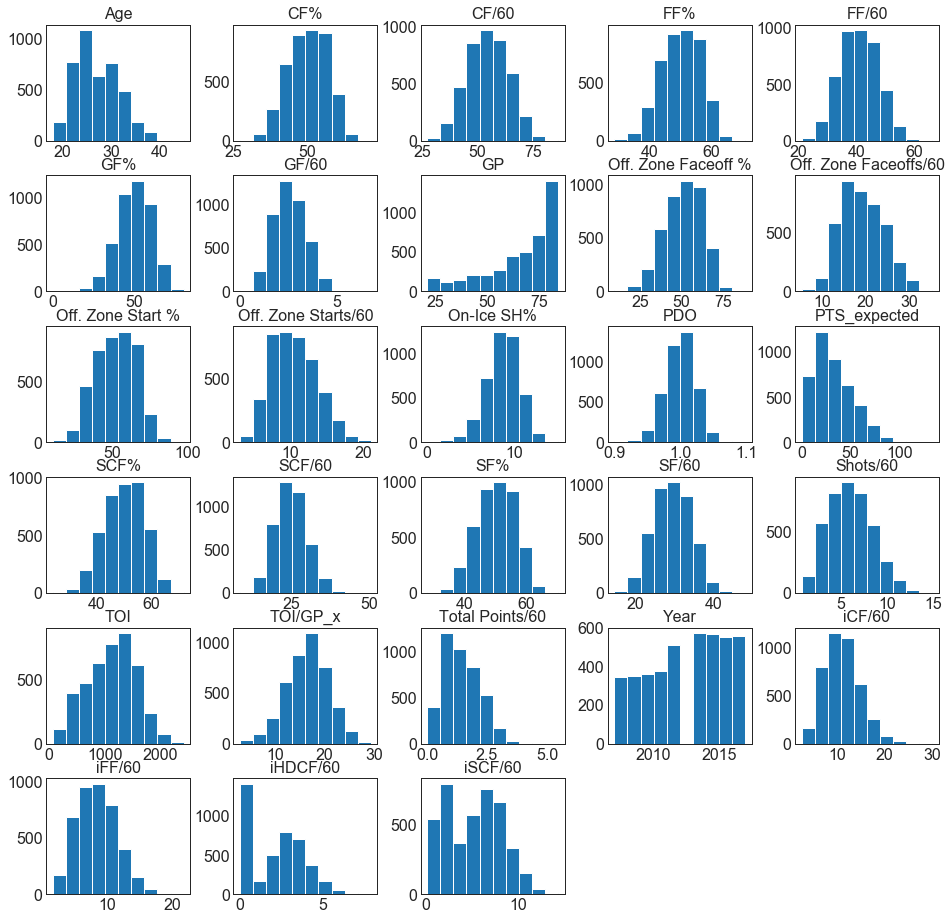

In [13]:
# Print histograms for each feature to see how they vary.
histograms = nhl_players_features.hist(grid=False, figsize=(16, 16))

## Feature engineering

In [14]:
# Feature Extractor
print('Extract features...')
from tsfresh.feature_extraction import *
features_filtered_direct = tsfresh.extract_features(nhl_players_features, 
                                                    column_id='Player', 
                                                    column_sort='Year',
                                                    default_fc_parameters=tsfresh.feature_extraction.settings.MinimalFCParameters())
 
# Convert NaN and inf
print('Impute NaN and Inf, remove zeros columns...')
features_filtered_direct = tsfresh.utilities.dataframe_functions.impute(features_filtered_direct)

# Remove zeros columns
features_filtered_direct = features_filtered_direct.loc[:, (features_filtered_direct != 0).any(axis=0)]

# Remove columns with same values
cols = list(features_filtered_direct)
nunique = features_filtered_direct.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
features_filtered_direct = features_filtered_direct.drop(cols_to_drop, axis=1)
print('Done.')

# Select relevant features
features_filtered_direct = features_filtered_direct.drop(list(filter(re.compile(".*_length").match, features_filtered_direct.columns)), axis=1)
features_filtered_direct = features_filtered_direct.drop(list(filter(re.compile(".*_sum_values").match, features_filtered_direct.columns)), axis=1)
features_filtered_direct = features_filtered_direct.drop(list(filter(re.compile(".*_standard_deviation").match, features_filtered_direct.columns)), axis=1)
features_filtered_direct = features_filtered_direct.drop(list(filter(re.compile("Age*").match, features_filtered_direct.columns)), axis=1)
# tsfresh.select_features(features_filtered_direct, total_points[:8], ml_task='regression')

Extract features...


Feature Extraction: 100%|██████████| 20/20 [00:03<00:00,  6.64it/s]


Impute NaN and Inf, remove zeros columns...
Done.


In [15]:
# Add current age, draft position
features_filtered_direct['Age'] = nhl_players.groupby('Player').tail(1).Age.values
features_filtered_direct['Overall Draft Position'] = nhl_players.groupby('Player').tail(1)['Overall Draft Position'].values

# Add stats from last year
features_filtered_direct['PTS_expected-1'] = nhl_players.groupby('Player').tail(1).PTS_expected.values

# Add Position and convert to categorical (1 is Defense and 0 is offense)
features_filtered_direct['Position'] = nhl_players.groupby('Player').tail(1).Position.values
features_filtered_direct = pd.concat([features_filtered_direct, pd.get_dummies(features_filtered_direct['Position'])], axis=1)
features_filtered_direct = features_filtered_direct.drop(['Position'], axis=1)
features_filtered_direct['Position'] = (features_filtered_direct['D'] == 1).astype(int)
features_filtered_direct = features_filtered_direct.drop(['C', 'C, L', 'C, R', 'D', 'L', 'L, R', 'R'], axis=1)

In [16]:
def normalizeFeature(feature):
    #Normalized Data
    return (feature-min(feature))/(max(feature)-min(feature))

In [17]:
# def getPlayerScore(player):
#     name = player.name
#     return normalizeFeature(features_filtered_direct['CF%__mean'])[name] + normalizeFeature(features_filtered_direct['FF%__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['GF%__mean'])[name] + normalizeFeature(features_filtered_direct['GP__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['Off. Zone Faceoff %__mean'])[name] + normalizeFeature(features_filtered_direct['Off. Zone Start %__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['On-Ice SH%__mean'])[name] - normalizeFeature(features_filtered_direct['PDO__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['PTS_expected__mean'])[name] + normalizeFeature(features_filtered_direct['SCF%__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['SF%__mean'])[name] + normalizeFeature(features_filtered_direct['SH%__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['Shots__mean'])[name] + normalizeFeature(features_filtered_direct['TOI__mean'])[name] + \
#             normalizeFeature(features_filtered_direct['PTS_expected-1'])[name]
def getPlayerScore(player):
    name = player.name
    return normalizeFeature(features_filtered_direct['CF%__mean'])[name] + normalizeFeature(features_filtered_direct['FF%__mean'])[name] + \
            normalizeFeature(features_filtered_direct['GF%__mean'])[name] + normalizeFeature(features_filtered_direct['GP__mean'])[name] + \
            normalizeFeature(features_filtered_direct['Off. Zone Faceoff %__mean'])[name] + normalizeFeature(features_filtered_direct['Off. Zone Start %__mean'])[name] + \
            normalizeFeature(features_filtered_direct['On-Ice SH%__mean'])[name] - normalizeFeature(features_filtered_direct['PDO__mean'])[name] + \
            normalizeFeature(features_filtered_direct['PTS_expected__mean'])[name] + normalizeFeature(features_filtered_direct['SCF%__mean'])[name] + \
            normalizeFeature(features_filtered_direct['SF%__mean'])[name] + \
            normalizeFeature(features_filtered_direct['Shots/60__mean'])[name] + normalizeFeature(features_filtered_direct['TOI__mean'])[name] + \
            normalizeFeature(features_filtered_direct['PTS_expected-1'])[name]                          

In [18]:
# Get player score
features_filtered_direct['Score'] = features_filtered_direct.apply(lambda player: getPlayerScore(player), axis=1)

# Saving feature names for later use
feature_list = list(features_filtered_direct.columns)

features_filtered_direct.head(10)

,CF%__maximum,CF%__mean,CF%__median,CF%__minimum,CF%__variance,CF/60__maximum,CF/60__mean,CF/60__median,CF/60__minimum,CF/60__variance,FF%__maximum,FF%__mean,FF%__median,FF%__minimum,FF%__variance,FF/60__maximum,FF/60__mean,FF/60__median,FF/60__minimum,FF/60__variance,GF%__maximum,GF%__mean,GF%__median,GF%__minimum,GF%__variance,GF/60__maximum,GF/60__mean,GF/60__median,GF/60__minimum,GF/60__variance,GP__maximum,GP__mean,GP__median,GP__minimum,GP__variance,Off. Zone Faceoff %__maximum,Off. Zone Faceoff %__mean,Off. Zone Faceoff %__median,Off. Zone Faceoff %__minimum,Off. Zone Faceoff %__variance,Off. Zone Faceoffs/60__maximum,Off. Zone Faceoffs/60__mean,Off. Zone Faceoffs/60__median,Off. Zone Faceoffs/60__minimum,Off. Zone Faceoffs/60__variance,Off. Zone Start %__maximum,Off. Zone Start %__mean,Off. Zone Start %__median,Off. Zone Start %__minimum,Off. Zone Start %__variance,Off. Zone Starts/60__maximum,Off. Zone Starts/60__mean,Off. Zone Starts/60__median,Off. Zone Starts/60__minimum,Off. Zone Starts/60__variance,On-Ice SH%__maximum,On-Ice SH%__mean,On-Ice SH%__median,On-Ice SH%__minimum,On-Ice SH%__variance,PDO__maximum,PDO__mean,PDO__median,PDO__minimum,PDO__variance,PTS_expected__maximum,PTS_expected__mean,PTS_expected__median,PTS_expected__minimum,PTS_expected__variance,SCF%__maximum,SCF%__mean,SCF%__median,SCF%__minimum,SCF%__variance,SCF/60__maximum,SCF/60__mean,SCF/60__median,SCF/60__minimum,SCF/60__variance,SF%__maximum,SF%__mean,SF%__median,SF%__minimum,SF%__variance,SF/60__maximum,SF/60__mean,SF/60__median,SF/60__minimum,SF/60__variance,Shots/60__maximum,Shots/60__mean,Shots/60__median,Shots/60__minimum,Shots/60__variance,TOI/GP_x__maximum,TOI/GP_x__mean,TOI/GP_x__median,TOI/GP_x__minimum,TOI/GP_x__variance,TOI__maximum,TOI__mean,TOI__median,TOI__minimum,TOI__variance,Total Points/60__maximum,Total Points/60__mean,Total Points/60__median,Total Points/60__minimum,Total Points/60__variance,iCF/60__maximum,iCF/60__mean,iCF/60__median,iCF/60__minimum,iCF/60__variance,iFF/60__maximum,iFF/60__mean,iFF/60__median,iFF/60__minimum,iFF/60__variance,iHDCF/60__maximum,iHDCF/60__mean,iHDCF/60__median,iHDCF/60__minimum,iHDCF/60__variance,iSCF/60__maximum,iSCF/60__mean,iSCF/60__median,iSCF/60__minimum,iSCF/60__variance,Age,Overall Draft Position,PTS_expected-1,Position,Score
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Aaron Ekblad,57.62,56.613333,56.890,55.33,0.912289,63.52,59.123333,59.840,54.01,15.330156,57.17,55.903333,55.570,54.97,0.862222,48.19,45.503333,46.160,42.16,6.275756,60.78,55.866667,60.270,46.55,43.443489,3.30,2.836667,2.990,2.22,0.206156,81.0,75.666667,78.0,68.0,30.888889,66.16,63.726667,64.510,60.51,5.627222,26.76,25.853333,26.600,24.20,1.371022,68.88,65.740000,68.160,60.18,15.543200,11.75,11.350000,11.650,10.65,0.246667,10.57,8.423333,8.460,6.24,3.125489,1.019,0.999667,1.0060,0.974,0.000358,38.0,33.333333,38.0,24.0,43.555556,58.48,56.113333,56.630,53.23,4.727222,26.83,26.110000,25.760,25.74,0.259267,58.39,56.583333,56.050,55.31,1.723289,35.57,34.040000,35.320,31.23,3.958467,9.25,7.160000,6.460,5.77,2.263400,21.810082,21.649089,21.677137,21.460049,0.020814,1766.616667,1638.905556,1690.816667,1459.283333,17089.678025,1.32,1.153333,1.280,0.86,0.043289,16.78,13.400000,11.920,11.50,5.741600,12.17,9.590000,8.520,8.08,3.360467,0.82,0.653333,0.660,0.48,0.019289,4.56,3.420000,3.050,2.65,0.676467,20,1,24.0,1,7.523204
Aaron Johnson,51.46,48.046667,47.000,45.68,6.115822,53.38,50.083333,51.430,45.44,11.414022,49.52,47.760000,47.360,46.40,1.702400,39.18,37.486667,37.220,36.06,1.657956,65.91,55.270000,55.260,44.64,75.402200,3.24,2.870000,3.030,2.34,0.147800,41.0,36.333333,38.0,30.0,21.555556,55.83,49.486667,47.790,44.84,21.569356,16.59,15.103333,14.510,14.21,1.120089,65.85,54.350000,53.780,43.42,84.013267,7.79,7.036667,7.150,6.17,0.443822,12.72,10.596667,10.710,8.36,3.174689,1.072,1.029000,1.0200,0.995,0.001029,20.0,13.333333,15.0,5.0,38.

## Scaling features

In [19]:
# Keep in memory the stats and convert df to np.array and floats
features_filtered_direct_columns = features_filtered_direct.columns
features = np.array(features_filtered_direct).astype('float')

# Create a standard scaler object
# std_scaler = preprocessing.StandardScaler()
std_scaler = preprocessing.RobustScaler()

# Create an object to transform the data to fit minmax processor
features = std_scaler.fit_transform(features)

In [20]:
# # Feature Extraction with PCA
# from sklearn.decomposition import PCA

# # feature extraction
# pca = PCA(n_components=50)
# features_components = pca.fit(features)
# features = pca.fit_transform(features)

# # summarize components
# print(f"Explained Variance: {features_components.explained_variance_ratio_}")

---
# Build Training and Test Sets

In [21]:
# Labels are the values we want to predict
labels = total_points.copy()

In [22]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [23]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1008, 135)
Training Labels Shape: (1008,)
Testing Features Shape: (253, 135)
Testing Labels Shape: (253,)


---
# Train/Test Model - RF

## Standard

In [27]:
%%time
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=1000, criterion='mse', verbose=1, n_jobs=-1, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels)
# scores = cross_val_score(rf, features_filtered_direct, labels, verbose=1, cv=5)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    7.9s


CPU times: user 1min 13s, sys: 219 ms, total: 1min 13s
Wall time: 10.4 s


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.9s finished


In [28]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    0.1s finished


Mean Absolute Error: 8.13 points.
Mean Squared Error: 121.18 points.
Explained Variance Score: 0.68
R2 Score: 0.68


In [ ]:
import graphviz 
dot_data = tree.export_graphviz(classification_tree, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("iris")

In [29]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances[:100]];

Variable: PTS_expected-1       Importance: 0.52
Variable: PTS_expected__minimum Importance: 0.04
Variable: Score                Importance: 0.04
Variable: Age                  Importance: 0.03
Variable: CF/60__minimum       Importance: 0.01
Variable: FF/60__minimum       Importance: 0.01
Variable: GP__variance         Importance: 0.01
Variable: Off. Zone Faceoffs/60__maximum Importance: 0.01
Variable: Off. Zone Faceoffs/60__mean Importance: 0.01
Variable: Off. Zone Faceoffs/60__median Importance: 0.01
Variable: Off. Zone Faceoffs/60__minimum Importance: 0.01
Variable: Off. Zone Starts/60__maximum Importance: 0.01
Variable: PTS_expected__maximum Importance: 0.01
Variable: PTS_expected__mean   Importance: 0.01
Variable: PTS_expected__median Importance: 0.01
Variable: SCF/60__median       Importance: 0.01
Variable: CF%__maximum         Importance: 0.0
Variable: CF%__mean            Importance: 0.0
Variable: CF%__median          Importance: 0.0
Variable: CF%__minimum         Importance: 0.

In [30]:
results = pd.DataFrame(test_labels)
results['Prediction'] = predictions
results['Difference'] = results.Prediction - results.PTS_expected
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

,PTS_expected,Prediction,Difference
count,253.000000,253.000000,253.000000
mean,25.521739,25.337621,-0.184119
std,19.530718,15.105172,11.028391
min,0.000000,4.951000,-53.406000
10%,7.000000,11.316200,-13.642800
25%,12.000000,13.542000,-6.425000
50%,20.000000,21.680000,1.500000
75%,34.000000,30.649000,7.127000
90%,51.000000,48.339600,11.415600
max,106.000000,83.010000,36.000000


In [31]:
results.sort_values('Difference')

,PTS_expected,Prediction,Difference
Player,,,
Nathan MacKinnon,106.0,52.594,-53.406
Erik Haula,59.0,16.446,-42.554
Josh Bailey,76.0,39.229,-36.771
Patrick Eaves,52.0,19.267,-32.733
Taylor Hall,100.0,67.689,-32.311
Gabriel Landeskog,65.0,37.576,-27.424
Evan Rodrigues,41.0,15.226,-25.774
John Carlson,68.0,44.174,-23.826
Tim Stapleton,34.0,11.428,-22.572


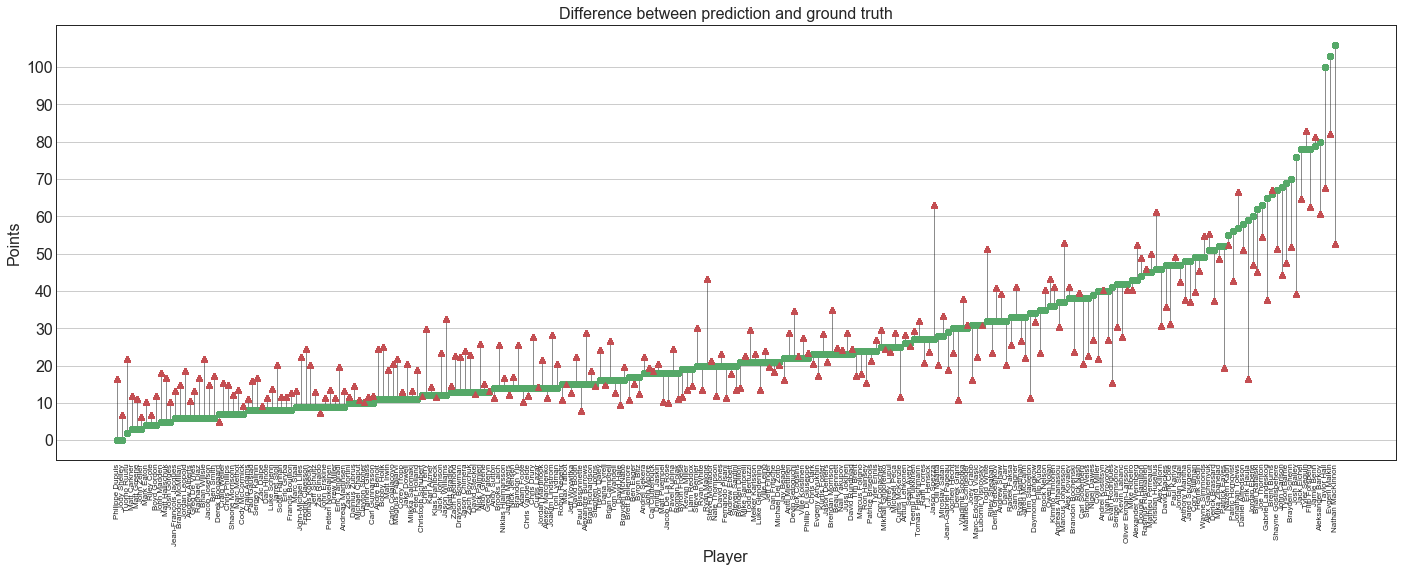

In [32]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();

## LR

In [ ]:
%%time
lr = LinearRegression()

# Train the model on training data
lr.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = lr.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

In [ ]:
results = pd.DataFrame(test_labels)
results['Prediction'] = predictions
results['Difference'] = results.Prediction - results.PTS_expected
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

In [ ]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();

## XGBoost

In [ ]:
%%time
xgb = xgboost.XGBRegressor(random_state=42)

# Train the model on training data
xgb.fit(train_features, train_labels, verbose=True, eval_metric='rmse');

In [ ]:
# Use the forest's predict method on the test data
predictions = xgb.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

In [ ]:
results = pd.DataFrame(test_labels)
results['Prediction'] = predictions
results['Difference'] = results.Prediction - results.PTS_expected
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

In [ ]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();

In [ ]:
def objective(space):

    clf = xgboost.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = space['max_depth'],
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:linear', 
                           random_state=space['random_state']
                           )
    
    clf.fit(train_features,
            train_labels,
            eval_metric = 'mae')

    pred = clf.predict(test_features)
    mae = mean_absolute_error((test_labels), (pred))
    
    print(f"SCORE: {mae}")
    print(f'{clf}')

    return {'loss':mae, 'status': STATUS_OK }

In [ ]:
%%time
space ={
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth': hp.choice('max_depth', np.arange(1, 30, dtype=int)),
        'min_child_weight': hp.quniform ('min_child_weight', 1, 20, 1),
        'subsample': hp.uniform ('subsample', 0.5, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(100, 10000, 100, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.05, 0.5, 0.01),
        'gamma' : hp.quniform('gamma', 0, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'random_state': 42,
        'eta': hp.quniform('eta', 0.025, 0.5, 0.025)
#         'eval_metric': 'auc',
#         'objective': 'binary:logistic',
#         'booster': 'gbtree',
#         'tree_method': 'exact',
#         'silent': 1,

    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=750, # change
            trials=trials)

print(best)

In [ ]:
%%time
# SCORE: 3.42675515289387
# XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#        colsample_bytree=0.55, gamma=0.55, learning_rate=0.05,
#        max_delta_step=0, max_depth=4, min_child_weight=20.0, missing=None,
#        n_estimators=2900, n_jobs=1, nthread=None, objective='reg:linear',
#        random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
#        seed=None, silent=True, subsample=0.635597208543029)
#
# OR
#
# {'colsample_bytree': 0.55, 'gamma': 0.55, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 20.0, 'n_estimators': 28, 'subsample': 0.635597208543029}
xgb = xgboost.XGBRegressor(colsample_bytree=0.55, gamma=0.55, learning_rate=0.05,
                           max_depth=4, min_child_weight=20, n_estimators=2900, 
                           subsample=0.635597208543029)

# Train the model on training data
xgb.fit(train_features, train_labels,
            eval_metric = 'mae');

In [ ]:
# Use the forest's predict method on the test data
predictions = xgb.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

## MLPRegressor

In [ ]:
%%time
mlp = MLPRegressor(hidden_layer_sizes=(20,), verbose=True, max_iter=1000, random_state=42)

# Train the model on training data
mlp.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = mlp.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

In [ ]:
results = pd.DataFrame(test_labels)
results['Prediction'] = predictions
results['Difference'] = results.Prediction - results.PTS_expected
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

In [ ]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();

## SVM

In [ ]:
%%time
svr = svm.SVR(kernel='linear', verbose=True)

# Train the model on training data
svr.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = svr.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

In [ ]:
results = pd.DataFrame(test_labels)
results['Prediction'] = predictions
results['Difference'] = results.Prediction - results.PTS_expected
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

In [ ]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();

## SGD

In [ ]:
%%time
from sklearn import linear_model
sgd = linear_model.SGDRegressor(max_iter=20000, tol=1e-4, penalty='elasticnet', learning_rate='adaptive', eta0=0.00001, verbose=1, random_state=42)

# Train the model on training data
sgd.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = sgd.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

In [ ]:
results = pd.DataFrame(test_labels)
results['Prediction'] = predictions
results['Difference'] = results.Prediction - results.PTS_expected
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

In [ ]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();

## KNN

In [ ]:
%%time
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=5, weights='distance')

# Train the model on training data
neigh.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = neigh.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

In [ ]:
results = pd.DataFrame(test_labels)
results['Prediction'] = predictions
results['Difference'] = results.Prediction - results.PTS_expected
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

In [ ]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();

## Boosting

In [ ]:
%%time
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor
est = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.001, max_depth=5, verbose=1, random_state=42)

# Train the model on training data
est.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = est.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

In [ ]:
results = pd.DataFrame(test_labels)
results['Prediction'] = predictions
results['Difference'] = results.Prediction - results.PTS_expected
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

In [ ]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();

## Ridge Regression

In [ ]:
%%time
from sklearn import linear_model
reg = linear_model.Ridge()

# Train the model on training data
reg.fit(train_features, train_labels);

In [ ]:
# Use the forest's predict method on the test data
predictions = reg.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

In [ ]:
results = pd.DataFrame(test_labels)
results['Prediction'] = predictions
results['Difference'] = results.Prediction - results.PTS_expected
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

In [ ]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();

## TPOT

In [ ]:
from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=100, population_size=100, verbosity=3, cv=2)
tpot.fit(train_features, train_labels)
print(tpot.score(train_features, train_labels))

In [ ]:
tpot.export('tpot_pipeline.py')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectPercentile, f_regression
from sklearn.linear_model import LassoLarsCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import MaxAbsScaler, PolynomialFeatures, StandardScaler
from tpot.builtins import StackingEstimator
from sklearn.preprocessing import FunctionTransformer
from copy import copy

# Average CV score on the training set was:-109.53604510235976
exported_pipeline = make_pipeline(
    make_union(
        StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True, max_features=0.3, min_samples_leaf=11, min_samples_split=18, n_estimators=100)),
        make_pipeline(
            make_union(
                make_union(
                    make_union(
                        StackingEstimator(estimator=make_pipeline(
                            StandardScaler(),
                            SelectPercentile(score_func=f_regression, percentile=20),
                            MaxAbsScaler(),
                            RidgeCV()
                        )),
                        FunctionTransformer(copy)
                    ),
                    FunctionTransformer(copy)
                ),
                StandardScaler()
            ),
            MaxAbsScaler(),
            StackingEstimator(estimator=RidgeCV()),
            PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
        )
    ),
    LassoLarsCV(normalize=False)
)
exported_pipeline.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = exported_pipeline.predict(test_features)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(mean_absolute_error(test_labels, predictions), 2), 'points.')

# Print out the mean squared error (mse)
print('Mean Squared Error:', round(mean_squared_error(test_labels, predictions), 2), 'points.')

# Print mean relative error
# print('Mean Relative Error', round(mean_absolute_percentage_error(test_labels, predictions), 2))

# Print explained variance
print('Explained Variance Score:', round(explained_variance_score(test_labels, predictions), 2))

# Print R2 score
print('R2 Score:', round(r2_score(test_labels, predictions), 2))

In [ ]:
results = pd.DataFrame(test_labels)
results['Prediction'] = predictions
results['Difference'] = results.Prediction - results.PTS_expected
results.sort_values('Difference', inplace=True)
results.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

In [ ]:
# Sorted indexes
sorted_index = np.argsort(test_labels)

fig, ax = plt.subplots(figsize=(24,8))

# plot a black line between the 
# ith prediction and the ith ground truth 
for i in range(len(predictions)):
    ax.plot([i,i],[predictions[sorted_index][i], test_labels[sorted_index][i]], c="k", linewidth=0.5)
    ax.plot(test_labels[sorted_index],'o', label='Ground Truth', color = 'g')
    ax.plot(predictions[sorted_index],'^', label='Prediction', color = 'r' )

plt.grid(axis='y')
plt.xlabel('Player')
plt.ylabel('Points')
plt.yticks(np.linspace(0, 100, 11))
plt.xticks(rotation=90, fontsize=8)
plt.title('Difference between prediction and ground truth')

plt.show();

In [ ]:
from bokeh.models import ColumnDataSource 
from bokeh.models import HoverTool

source = ColumnDataSource(data=dict(
    x=range(len(predictions)),
    y=test_labels[sorted_index],
    desc=test_labels[sorted_index].index,
    real=test_labels[sorted_index],
    pred=predictions[sorted_index]
))

preds = ColumnDataSource(data=dict(
    x=range(len(predictions)),
    y=predictions[sorted_index],
    desc=test_labels[sorted_index].index,
    real=test_labels[sorted_index],
    pred=predictions[sorted_index]
))

segs = ColumnDataSource(data=dict(
    x0=range(len(predictions)),
    y0=test_labels[sorted_index],
    x1=range(len(predictions)),
    y1=predictions[sorted_index],
    desc=test_labels[sorted_index].index,
))

TOOLTIPS = [
    ("desc", "@desc"),
    ("real", "@real"),
    ("pred", "@pred")
]

hover = HoverTool(names=["pred", "test"])
TOOLS="crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

p = figure(tools=[TOOLS, hover], tooltips=TOOLTIPS, plot_width=1500, plot_height=500)

p.segment('x0', 'y0', 'x1', 'y1', source=segs, line_alpha=0.6, color="red", line_width=2)

p.scatter('x', 'y', name='test',
          color='green', size=5, source=source,
          line_color=None)

p.scatter('x', 'y', name='pred',
          color='red', size=5, marker='square', source=preds, fill_alpha=0.6, 
          line_color=None)

show(p)  # open a browser

In [ ]:
# Plot
results_abs = results.copy()
results_abs['Difference'] = abs(results_abs['Difference'])
gridobj = sns.lmplot(x="Prediction", y="PTS_expected", data=results, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

# Decorations
gridobj.set(xlim=(-1, max(results['Prediction']+10)), ylim=(-1, max(results['PTS_expected']+10)))
plt.title("Scatterplot with line of best fit", fontsize=20)
plt.grid(axis='both')
plt.xticks(np.linspace(0, 100, 11))
plt.yticks(np.linspace(0, 120, 13))
plt.show();